The kaggle.json file contains your Kaggle API credentials, which allow you to download datasets and submit competition entries through the Kaggle API. The ~/.kaggle directory is the default location where the Kaggle API client expects to find the kaggle.json file.

In [1]:
# For Google Colab
!pip install -q kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [2]:
# For Google Colab
#Download the dataset from kaggle
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:33<00:00, 92.4MB/s]
100% 3.10G/3.10G [00:33<00:00, 98.2MB/s]


In [3]:
import numpy as np #for numeric computation of arrays
import matplotlib.pyplot as plt #for plotting
import os #for simply working on files and folder
import cv2 #for image preprocessing
from tensorflow.python.keras.models import Model #for funtional API models
from sklearn.model_selection import train_test_split #to split the datasets
from tensorflow.keras.utils import to_categorical #for converting the labels into one-hot-encode
from tensorflow.keras.utils import plot_model #for plotting the model achitecture
from tensorflow.keras.layers import Dense #for Dense layer network
from tensorflow.keras.layers import Flatten #for flatten image
from tensorflow.keras.layers import  Dropout #for turnnig off some of the nodes in a layer
from tensorflow.keras.layers import Conv2D #for a Convolutional layer
from tensorflow.keras.layers import AveragePooling2D #for performing a average pooling on the network
from tensorflow.keras.layers import MaxPooling2D #for performing a maximum pooling layer
from tensorflow.keras.layers import concatenate #for adding two layer
from tensorflow.keras.layers import Input #for specifying the input shape
from tensorflow.keras.layers import Activation #for performing an activation on the layers
from keras.layers import BatchNormalization #for normalizing the input layer
from tensorflow.keras.regularizers import l1 #to reduce overfitting
from tensorflow.keras.optimizers import Adam #to apply optimization to the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, load_model

1. 'os.mkdir("datasets")' creates a new directory called datasets.

2. !unzip breast-histopathology-images.zip -d datasets extracts the contents of the breast-histopathology-images.zip file into the datasets directory. The -d flag specifies the destination directory for the extracted files.

3. '%%capture' suppresses the output of the unzip command.

In [4]:
# For Google Colab
%%capture
os.mkdir("datasets")
!unzip breast-histopathology-images.zip -d datasets

The code reads the label IDs for a dataset from the datasets directory.

In [5]:
label_ids = []
label_classes = ['0', '1']

for label_id in os.listdir('datasets'):
    label_ids.append(str(label_id))

label_ids.remove('IDC_regular_ps50_idx5')

The **get_datasets()** function takes four arguments: **folder** (the name of the directory containing the labeled image subdirectories), **label_ids** (a list of the label IDs for the images), **label_classes** (a list of the label classes for the images), and size (the size to which each image should be resized).
The datasets list will be used to store the image data and labels.
The function iterates over each label ID in the **label_ids** list and for each ID, it iterates over each label class in the **label_classes** list.
The function constructs a path to the image subdirectory using **os.path.join()** and the current label ID and label class.
The function then iterates over each image file in the subdirectory using **os.listdir()**.
For each image file, the function reads the image data using **cv2.imread()**, converts the color format from BGR to RGB using **cv2.cvtColor()**, and resizes the image using **cv2.resize()**.
The image data and label (as an index into the **label_classes** list) are added to the datasets list.
If an error occurs while processing an image (such as the file not being a valid image file), the function skips the image using a **try/except** block.
Once all images have been processed, the function returns the datasets list.

In [6]:
def get_datasets(folder, label_ids, label_classes, size=30):
    datasets = []
    for label_id in label_ids:
        for label_class in label_classes:
            path = os.path.join(folder, label_id)
            path = os.path.join(path, label_class)
            index = label_classes.index(label_class)

            for image in os.listdir(path):
                try:
                    images = cv2.imread(os.path.join(path, image))
                    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
                    images = cv2.resize(images, (size, size))
                    datasets.append([images, index])
                except:
                    pass

    return datasets

In [7]:
datasets = get_datasets('datasets', label_ids, label_classes)

In [8]:
#suffle the datasets
np.random.shuffle(datasets)

In [9]:
#The following code is to separate the images of positive breast cancer and
# that which is not positive (negative)

datasets_0 = []
datasets_1 = []


for i in range(len(datasets)):
    if datasets[i][1] == 0:
        datasets_0.append(datasets[i])
    elif datasets[i][1] == 1:
        datasets_1.append(datasets[i])

In [10]:
# the following is done to have equal number of negative and positive breast
# cancer images
new_datasets_0 = []

for i in range(78786):
    new_datasets_0.append(datasets_0[i])

In [26]:
datasets_1 = np.array(datasets_1, dtype=object)
new_datasets_0 = np.array(new_datasets_0, dtype=object)

In [27]:
dataset = np.concatenate([new_datasets_0, datasets_1])

In [28]:
i = 0
v = 0

for n in range(len(dataset)):
    if dataset[n][1] == 0:
        i += 1
    elif dataset[n][1] == 1:
        v += 1

print(i)
print(v)

78786
78786


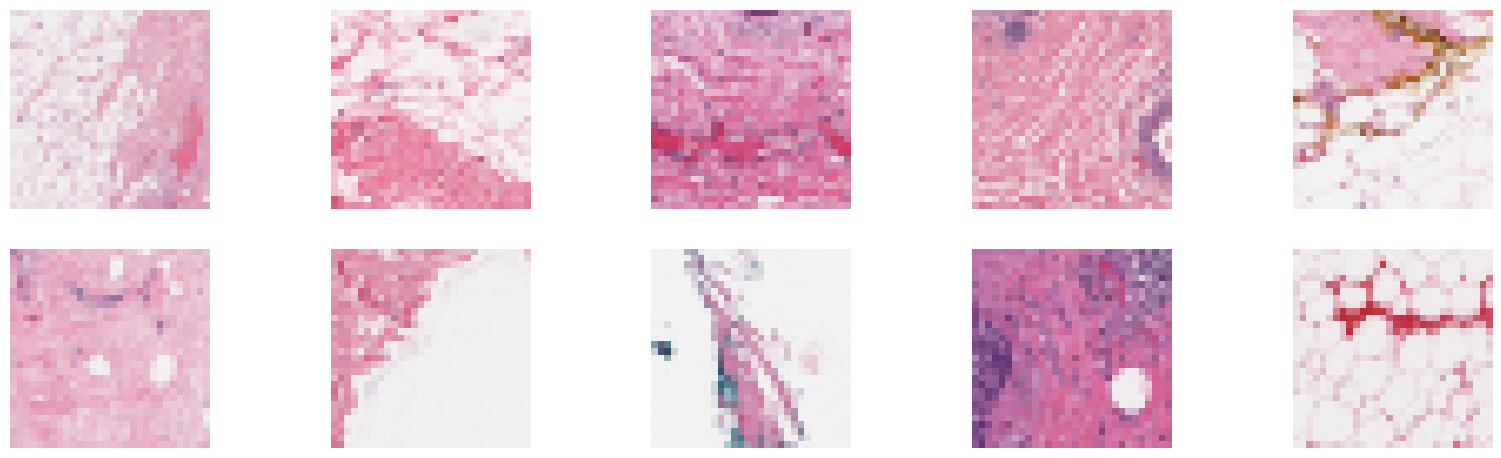

In [29]:
#display a sample of the images using matplotlib
n = 10

plt.figure(figsize=(20, 15))
for i in range(n):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(dataset[i][0])
    plt.axis('off')

plt.show()

In [30]:
def preprocessing_datasets(datasets):
    x = []
    y = []

    #categorize the train and test datasets(which contains both images and labels together in a list)
    for features, labels in datasets:
        x.append(features)
        y.append(labels)


    #convert both the train and test datasets into an array
    x = np.array(x).reshape(-1, 30, 30, 3) #the -1 is for the
    #number of images, and the 30 is for the size, and the 3 is for the
    #color channel(which is RGB)

    y = np.array(y).reshape(-1, 1)

    print(len(x))
    print(len(y))

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    #normalizing the image dataset
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    return x_train, x_test, y_train, y_test

In [31]:
x_train, x_test, y_train, y_test = preprocessing_datasets(dataset)

157572
157572


In [32]:
# Create the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


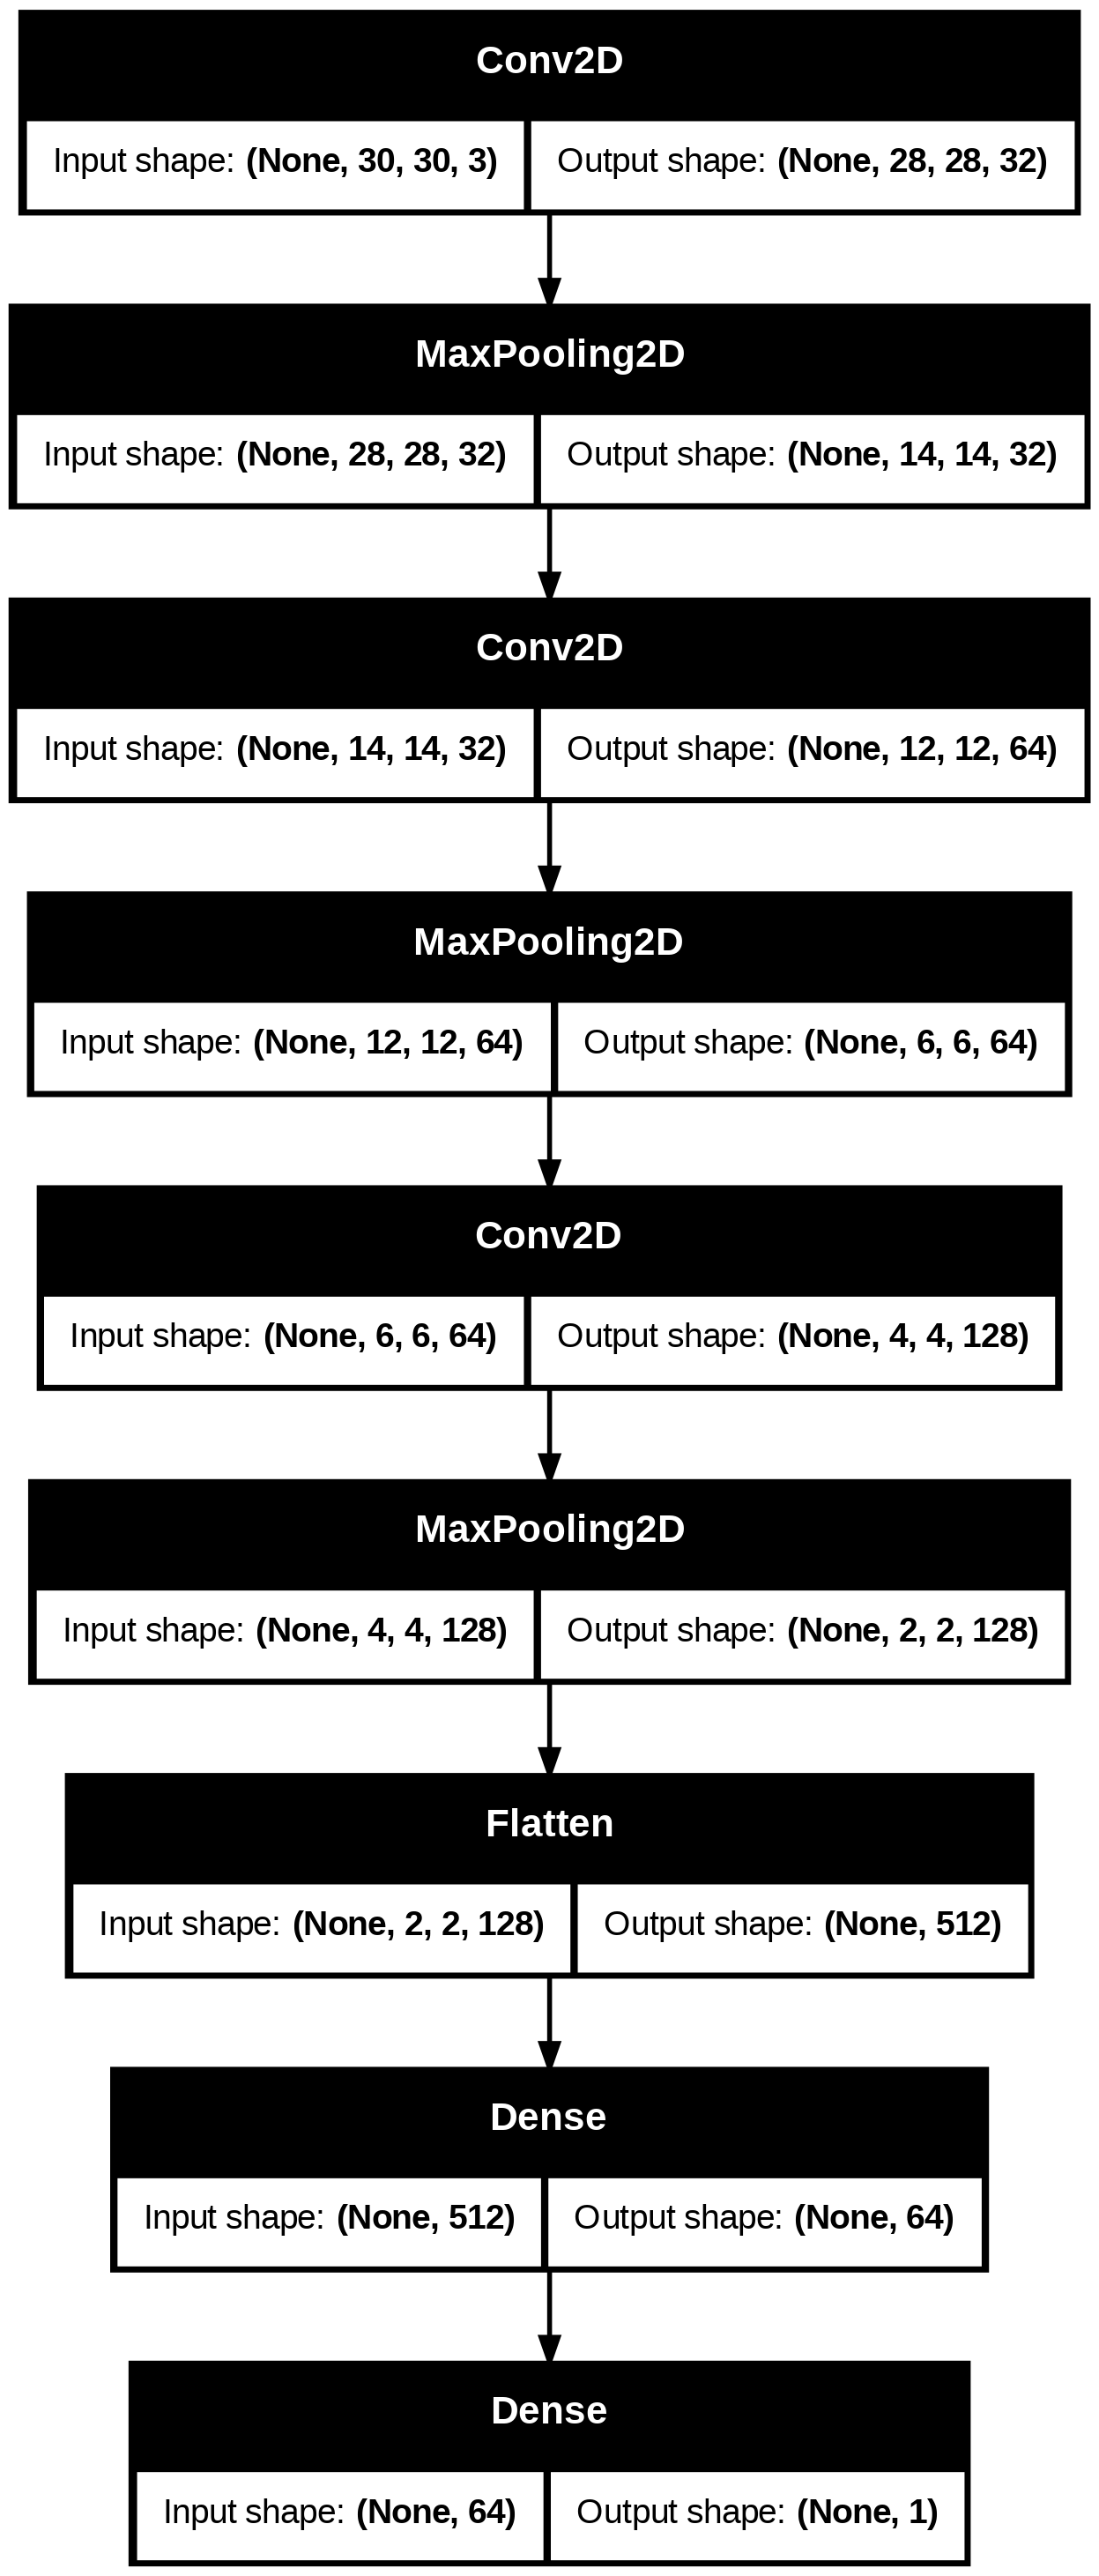

In [33]:
plot_model(model, show_shapes=True)

In [34]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=120, epochs=100)

Epoch 1/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7418 - loss: 0.5251 - val_accuracy: 0.8078 - val_loss: 0.4326
Epoch 2/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8100 - loss: 0.4297 - val_accuracy: 0.8166 - val_loss: 0.4116
Epoch 3/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8230 - loss: 0.4057 - val_accuracy: 0.8297 - val_loss: 0.3916
Epoch 4/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8309 - loss: 0.3938 - val_accuracy: 0.8353 - val_loss: 0.3806
Epoch 5/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8338 - loss: 0.3863 - val_accuracy: 0.8404 - val_loss: 0.3766
Epoch 6/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8431 - loss: 0.3681 - val_accuracy: 0.8404 - val_loss: 0.3699
Epoch 7/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8430 - loss: 0.3697 - val_accuracy: 0.8294 - val_loss: 0.3934
Epoch 8/100
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8458 - loss

In [35]:
model.save('model.h5')

In [38]:
import cv2

model_path = os.path.join(os.getcwd(), "model.h5")
saved_model = load_model(
        model_path,
    )

image = cv2.imread("cancer.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (30, 30))

image = image.reshape((-1, image.shape[0], image.shape[1], image.shape[2]))
image = np.float32(image) / 255

prediction = saved_model.predict(image)
# predicted_label = np.argmax(prediction, axis=1)[0]

print(prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
0.981746
